# Forecasting

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

In [13]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data
    Args:
        x (array of int) - contains values for the x-axis
        y (array of int or tuple of arrays) - contains the values for the y-axis
        format (string) - line style when plotting the graph
        start (int) - first time step to plot
        end (int) - last time step to plot
        title (string) - title of the plot
        xlabel (string) - label for the x-axis
        ylabel (string) - label for the y-axis
        legend (list of strings) - legend for the plot
    """
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:
        # Loop over the y elements
        for y_curr in y:
            # Plot the x and current y values
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        # Plot the x and y values
        plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
        plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Parse data from CSV

Download Data Set: https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

In [77]:
with open('./Sunspots.csv', 'r') as csvfile:
    print(f"Header looks like this:\n{csvfile.readline()}")
    print(f"First data point looks like this:\n{csvfile.readline()}")

Header looks like this:
,Date,Monthly Mean Total Sunspot Number

First data point looks like this:
0,1749-01-31,96.7



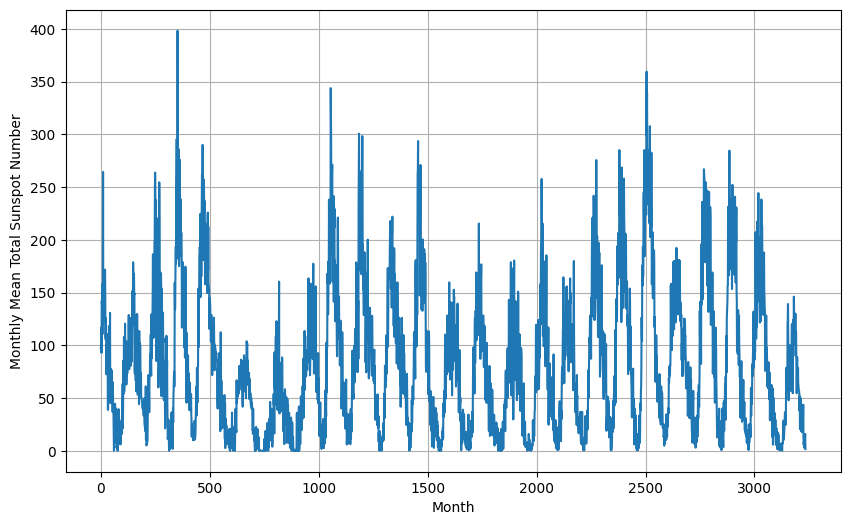

In [14]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

    # Initialize reader
    reader = csv.reader(csvfile, delimiter=',')

    # Skip the first line
    next(reader)

    # Append row and sunspot number to lists
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [15]:
# Define the split time
SPLIT_TIME = 3000

# Get the train set
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]

# Get the validation set
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

## Prepare Features and Labels

In [16]:
# Parameters
WINDOW_SIZE = 30
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows
    Args:
        series (array of float) - contains the values of the time series
        window_size (int) - the number of time steps to include in the feature
        batch_size (int) - the batch size
        shuffle_buffer(int) - buffer size to use for the shuffle method
    Returns:
        dataset (TF Dataset) - TF Dataset containing time windows
    """
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [18]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [19]:
# Print shapes of feature and label
for window in train_set.take(1):
    print(f'shape of feature: {window[0].shape}')
    print(f'shape of label: {window[1].shape}')

shape of feature: (32, 30)
shape of label: (32,)


## Model

In [20]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 lambda_1 (Lambda)           (None, 1)                

## Tune the Learning Rate

In [21]:
# Get initial weights
init_weights = model.get_weights()

In [22]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=10, callbacks=[lr_schedule])

Epoch 1/10
93/93 [==============================] - 8s 36ms/step - loss: 145.6947 - lr: 1.0000e-08
Epoch 2/10
93/93 [==============================] - 2s 22ms/step - loss: 107.8034 - lr: 1.1220e-08
Epoch 3/10
93/93 [==============================] - 2s 22ms/step - loss: 64.3954 - lr: 1.2589e-08
Epoch 4/10
93/93 [==============================] - 2s 22ms/step - loss: 33.9084 - lr: 1.4125e-08
Epoch 5/10
93/93 [==============================] - 2s 22ms/step - loss: 30.0606 - lr: 1.5849e-08
Epoch 6/10
93/93 [==============================] - 2s 23ms/step - loss: 27.3620 - lr: 1.7783e-08
Epoch 7/10
93/93 [==============================] - 2s 22ms/step - loss: 25.3534 - lr: 1.9953e-08
Epoch 8/10
93/93 [==============================] - 2s 22ms/step - loss: 23.9494 - lr: 2.2387e-08
Epoch 9/10
93/93 [==============================] - 2s 22ms/step - loss: 23.1271 - lr: 2.5119e-08
Epoch 10/10
93/93 [==============================] - 2s 22ms/step - loss: 22.5910 - lr: 2.8184e-08


ValueError: x and y must have same first dimension, but have shapes (100,) and (10,)

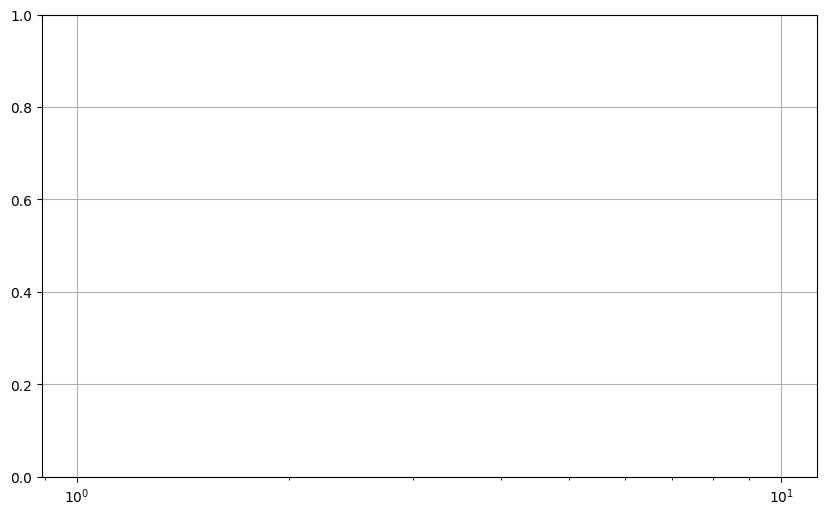

In [23]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=100, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

In [24]:
val_set = windowed_dataset(x_valid, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [68]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        '''
        Halts the training when a certain metric is met
        Args:
            epoch (integer) - index of epoch (required but unused in the function definition below)
            logs (dict) - metric results from the training epoch
        '''
        # Check the validation set MAE
        if logs.get('val_mae') < 6:
            # Stop if threshold is met
            print("\nRequired val MAE is met so cancelling training!")
            self.model.stop_training = True

    def on_epoch_begin(self, epoch, logs={}):
        print("Learning Rate: {}".format(self.model.optimizer._decayed_lr(tf.float32).numpy()))

# Instantiate the class
callbacks = MyCallback()

In [69]:
# Reset the weights
model.set_weights(init_weights)

At some point, the static learning rate might no longer be the optimal when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function, or use ExponentialDecay(). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
    return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

In [71]:
# Set the learning rate
initial_learning_rate = 8e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=400, decay_rate=0.96, staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[callbacks])

Learning Rate: 8.000000093488779e-07
Epoch 1/100
93/93 [==============================] - 7s 33ms/step - loss: 17.9185 - mae: 18.4094 - val_loss: 13.1759 - val_mae: 13.6589
Learning Rate: 8.000000093488779e-07
Epoch 2/100
93/93 [==============================] - 2s 22ms/step - loss: 18.3061 - mae: 18.7993 - val_loss: 14.3393 - val_mae: 14.8325
Learning Rate: 8.000000093488779e-07
Epoch 3/100
93/93 [==============================] - 2s 26ms/step - loss: 17.9040 - mae: 18.3954 - val_loss: 13.9769 - val_mae: 14.4663
Learning Rate: 8.000000093488779e-07
Epoch 4/100
93/93 [==============================] - 2s 23ms/step - loss: 18.1956 - mae: 18.6843 - val_loss: 14.1770 - val_mae: 14.6659
Learning Rate: 8.000000093488779e-07
Epoch 5/100
93/93 [==============================] - 2s 23ms/step - loss: 17.7614 - mae: 18.2532 - val_loss: 14.3336 - val_mae: 14.8224
Learning Rate: 7.680000067011861e-07
Epoch 6/100
93/93 [==============================] - 2s 23ms/step - loss: 17.9326 - mae: 18.4249 -

## Accuracy and Loss

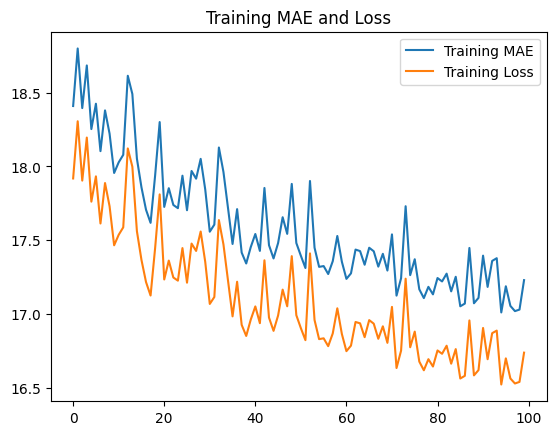

<Figure size 640x480 with 0 Axes>

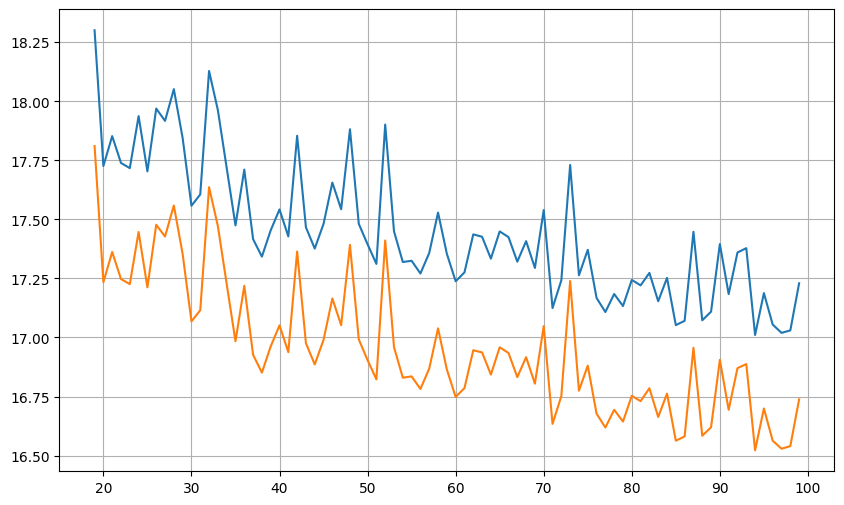

In [72]:
def plot_acc_val(history):
    mae = history.history['mae']
    loss = history.history['loss']
    epochs = range(len(mae)) # Get number of epochs

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, mae, label='Training MAE')
    plt.plot(epochs, loss, label='Training Loss')
    plt.title('Training MAE and Loss')
    plt.legend()
    plt.figure()

    # Only plot the last 80% of the epochs
    zoom_split = int(epochs[-1] * 0.2)
    epochs_zoom = epochs[zoom_split:]
    mae_zoom = mae[zoom_split:]
    loss_zoom = loss[zoom_split:]

    # Plot zoomed mae and loss
    plot_series(epochs_zoom, (mae_zoom, loss_zoom))

plot_acc_val(history)

## Model Prediction

In [73]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows
    Args:
        model (TF Keras Model) - model that accepts data windows
        series (array of float) - contains the values of the time series
        window_size (int) - the number of time steps to include in the window
        batch_size (int) - the batch size
    Returns:
        forecast (numpy array) - array containing predictions
    """
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 [==============================] - 1s 12ms/step


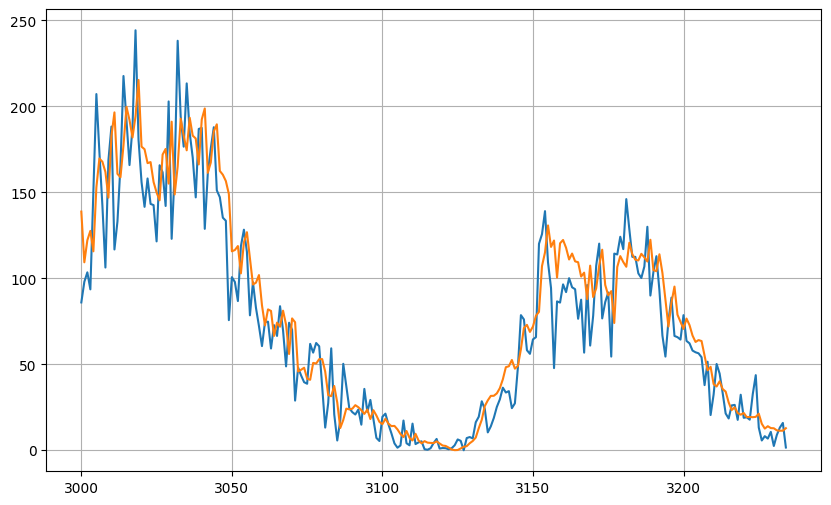

In [74]:
# Reduce the original series
forecast_series = series[SPLIT_TIME - WINDOW_SIZE: -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [75]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

483.60953
15.673469
